# Optymalizacja ciągła
## Labolatorium 6: Metoda gradientów sprzężonych

Standardowo, poniżej masz gotową implementację metody złotego podziału, metody Newtona i metody spadku wzdłuż gradientu z poprzednich zajęć.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from helpers import LineSearchError, aprroximate_line_search

plt.style.use("ggplot") # tak żeby wykresy były ładniejsze
%matplotlib inline

def golden_proportion_method(function, a=-10, b=10, epsilon=1e-8, max_steps=1000):
    alpha = (5 ** 0.5 - 1) / 2
    steps = 0
    xl = alpha * a + (1 - alpha) * b
    xr = (1 - alpha) * a + alpha * b
    fxl = function(xl)
    fxr = function(xr)

    while b - a > epsilon:
        m = (b + a) / 2
        if fxl < fxr:
            b = xr
            xr = xl
            fxr = fxl
            xl = alpha * a + (1 - alpha) * b
            fxl = function(xl)
        else:
            a = xl
            xl = xr
            fxl = fxr
            xr = (1 - alpha) * a + alpha * b
            fxr = function(xr)
        steps += 1
        if steps >= max_steps:
            break
    return (a + b) / 2

from helpers import plot_gd_1d,  plot_gd_2d


def run_cauchy(f, gradient, initial_x):
    """
    Algorytm Cauchy'iego dla funkcji n wymiarowych
    Wejście: 
       f (vector_x)- funkcja do optymalizacji
       gradient (vector_x)- gradient funkcji do optymalizacji
       initial_x - >wektor< koordynat punktu startowego
    Wyjście: minimum funkcji f
    """
    x_in_time = [initial_x] #historia odwiedzonych punktów
    x = np.copy(initial_x) #przepisanie początkowego wektora koordynat do x
    D = initial_x.shape[0] #liczba wymiarów problemu
    for i in range(500):
        g= gradient(x)
        alphax = golden_proportion_method(lambda alpha: f(x-alpha*gradient(x)) ,0,10)
        x-=alphax*g
        x_in_time.append(np.copy(x))
        if np.linalg.norm(g) < 1e-5:
            break

    #rysuj wynik
    if D==1:
        plot_gd_1d(f, x_in_time)
    else:
        plot_gd_2d(f, x_in_time, contours=True)
        
        
def run_gd(f, gradient, eta, d =1, initial_x = None, axis_range=None):
    """
    Algorytm spadku wzdłuż gradientu dla funkcji n wymiarowych
    Wejście: 
       f (vector_x)- funkcja do optymalizacji
       gradient (vector_x)- gradient funkcji do optymalizacji
       eta - długość kroku
       initial_x - >wektor< koordynat punktu startowego
    Wyjście: minimum funkcji f
    """
    assert d in [1,2]
    if initial_x is None:
        initial_x = np.random.random(d)
    x_in_time = [initial_x]

    minimal_change = 0.00001
    max_number_of_steps = 500

    for j in range(max_number_of_steps):
        last_x = x_in_time[-1]
        g = gradient(last_x)
        current_x = last_x - eta * g
        x_in_time.append(current_x)
        if np.linalg.norm(g) < 1e-5:
            break       
    if d==1:
        plot_gd_1d(f, x_in_time, axis_range=axis_range)
    else:
        plot_gd_2d(f, x_in_time, contours=True, axis_range=axis_range)
    return x_in_time

def run_newton(f, gradient, hesian, d = 1, initial_x = None, axis_range = None):
    """
    f - funkcja celu
    gradient - funkcja zwracająca gradient
    hesian - funkcja zwracająca hesjan
    d - wymiarowość problemu (1,2)
    initial_x - punkt startowy algorytmu
    axis_range - zakres rysowania wykresu
    """
    assert d in [1,2]
    if initial_x is None:
        initial_x = np.random.random(d)
    x_in_time = [initial_x]

    minimal_change = 0.00001
    max_number_of_steps = 100

    for j in range(max_number_of_steps):
        last_x = x_in_time[-1]
        g = gradient(last_x)
        if d == 2:
            current_x = last_x - np.linalg.inv(hesian(last_x))@g
        else:
            hes = hesian(last_x)
            if hes != 0:
                current_x = last_x - g/hesian(last_x)
        x_in_time.append(current_x)
        if np.linalg.norm(g) < 1e-5:
            break     
    if d==1:
        plot_gd_1d(f, x_in_time, axis_range=axis_range)
    else:
        plot_gd_2d(f, x_in_time, contours=True, axis_range=axis_range)
    return x_in_time



## Zadanie 1

Zaimplementuj metodę gradientów sprzężonych licząc $\beta$ na dwa sposoby:

1. Wzór Fletchera-Reevesa:
$$\beta = \frac{-g_{t+1}^Tg_{t+1}}{g_{t}^Tg_{t}}$$
gdzie $g_t$ oznacza gradient w punkcie $x_t$. Wzór ten w porównaniu ze wzorem z tablicy wykorzystuje dodatkowe matematyczne fakty:
  - Po przemnożeniu mianownika mamy dwa termy $d_i^Tg_{t+1} - d_i^Tg_{t}$ gdzie
    - $d_i^Tg_{t+1} = 0 $ gradienty w tej metodzie są prostopadłe do poprzednich kierunków optymalizacji
    - $-d_i^Tg_{t} = g_{t}^Tg_{t} $
  - Po przemnożeniu licznika $g_{t+1}^Tg_{t}=0$ gradienty są ortogonalne do poprzednich gradientów dla funkcji kwadratowej.

2. Wzór Polaka-Ribi`ere’a:
$$\beta = \frac{-g_{t+1}^T(g_{t+1}-g_{t})}{g_{t}^Tg_{t}}$$
jest bardziej podobny do tego z tablicy - w liczniku nie wykorzystujemy faktu, że $g_{t+1}^Tg_{t}=0$ ponieważ nie jest to prawda dla funkcji nie-kwadratowej. Z tego powodu metoda ta jest preferowana w praktyce dla ogólniejszych funkcji.

*Uwaga: operator mnożenia macierzowego @ ma niższy priotytet niż dzielenie / -- użyj nawiasów.*

In [2]:
def run_cg(f, gradient, initial_x, fletcher = False):
    """
    Algorytm Gradientów Sprzężonych dla funkcji n wymiarowych
    Wejście: 
       f (vector_x)- funkcja do optymalizacji
       gradient (vector_x)- gradient funkcji do optymalizacji
       initial_x - >wektor< koordynat punktu startowego
       fletcher - wybór wariantu metody
    Wyjście: minimum funkcji f
    """
    x_in_time = [initial_x] #historia odwiedzonych punktów
    x = np.copy(initial_x) #przepisanie początkowego wektora koordynat do x
    D = initial_x.shape[0] #liczba wymiarów problemu
    beta, mian, licz = [0.0, 1, 1]
    
    d = - gradient(x)
    for i in range(D):
        eta = golden_proportion_method(lambda eta: f(x + eta * d), a=0)
        x += eta * d
        x_in_time.append(np.copy(x))
        
        if fletcher:
            mian = gradient(x_in_time[-2]).T @ gradient(x_in_time[-2])
            licz = (- gradient(x).T @ gradient(x))
        else:
            mian = gradient(x_in_time[-2]).T @ gradient(x_in_time[-2])
            licz = - gradient(x).T @ (gradient(x) - gradient(x_in_time[-2]))

        beta = licz / mian
        d = - gradient(x) - beta * d
    
    #rysuj wynik
    if D==1:
        plot_gd_1d(f, x_in_time)
    else:
        plot_gd_2d(f, x_in_time, contours=True)
    return x_in_time
        


Przetestuj twój algorytm dla funkcji $2x^2+y^2$

[array([4., 4.]),
 array([-0.44444443,  1.77777778]),
 array([-4.96529795e-09, -1.04036570e-08])]

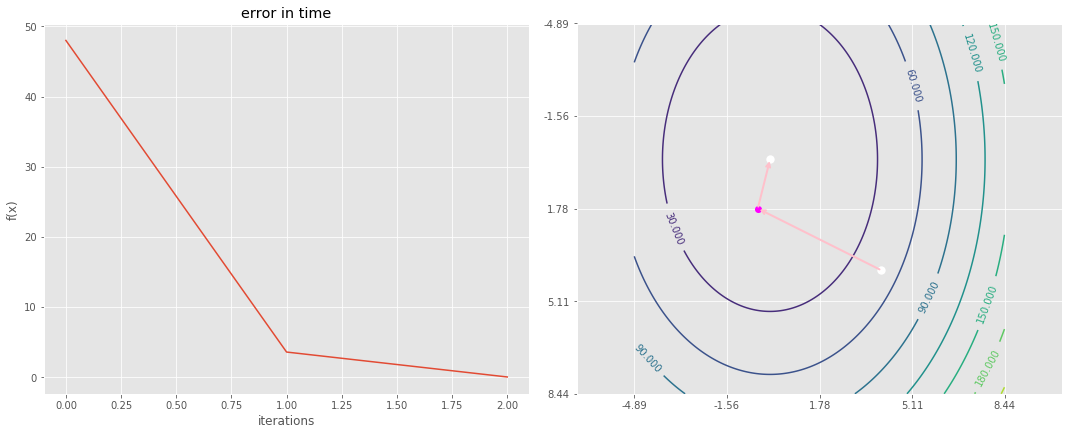

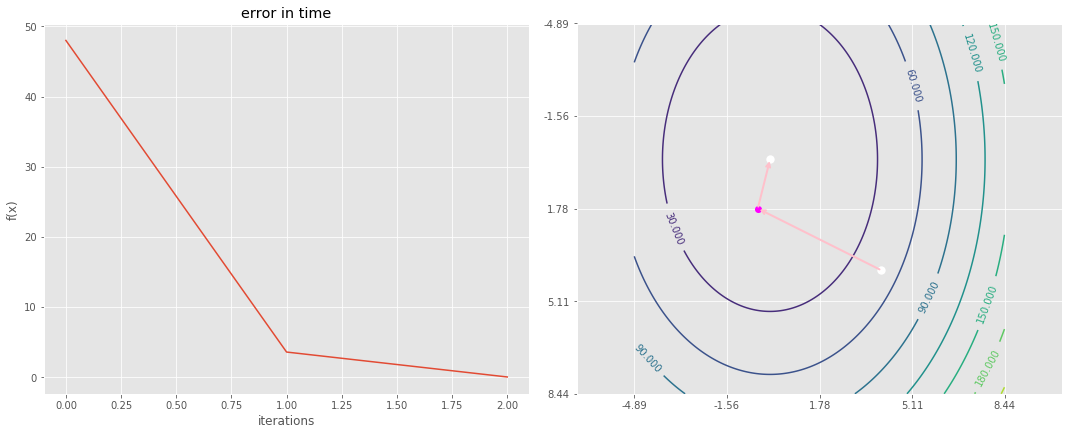

In [3]:
A = np.array([[2, 0], [0, 1]])

f = lambda x: x.T @ A @ x
gradient = lambda x: 2 * A @ x


run_cg(f, gradient, initial_x = np.array([4.,4.]))
run_cg(f, gradient, initial_x = np.array([4.,4.]), fletcher=True)

To było proste. Ale co się stanie z funkcją w której zmienne nie są niezależne? Przetestuj funkcję 
$x^TAx$ gdzie $A =  
\begin{bmatrix}
  1&2\\2&10
\end{bmatrix}$. Porównaj działanie metody z algorytmem Newtona i spadku wzdłuż gradientu.

[array([4., 4.]),
 array([ 2.84745761, -0.61016957]),
 array([3.53576631e-07, 1.40792630e-06])]

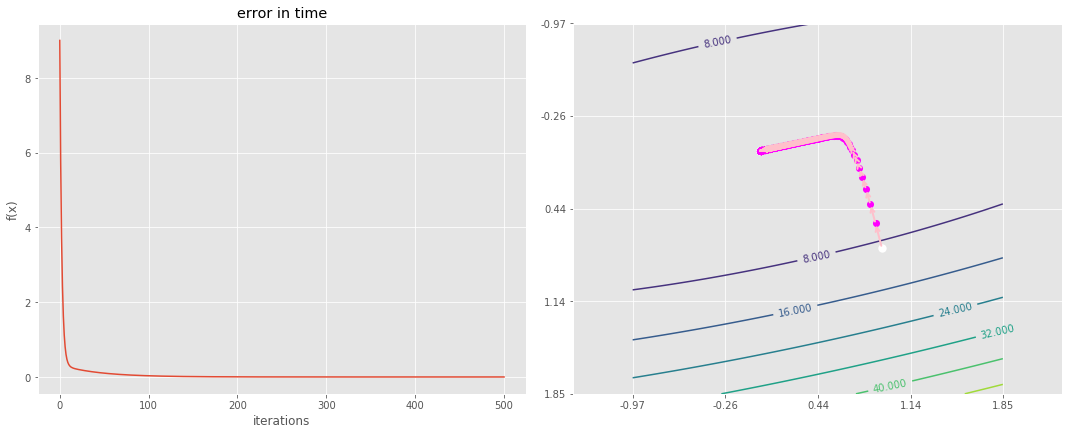

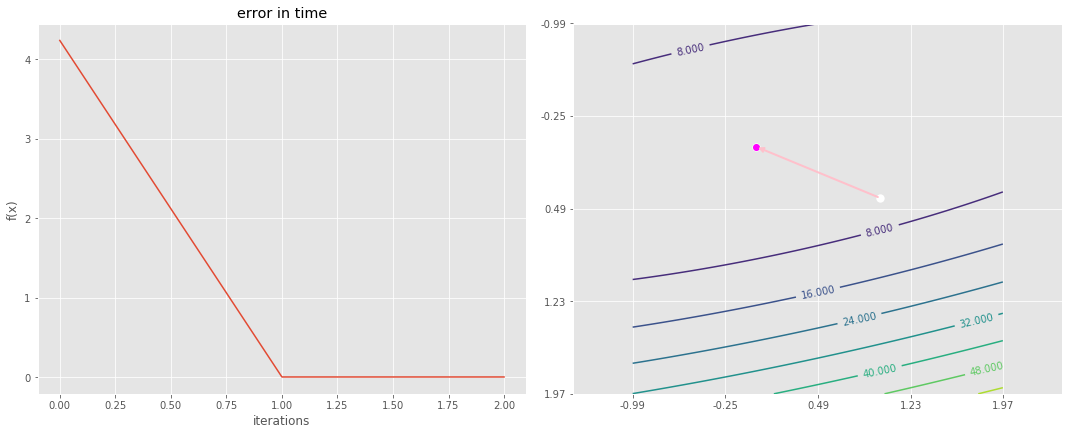

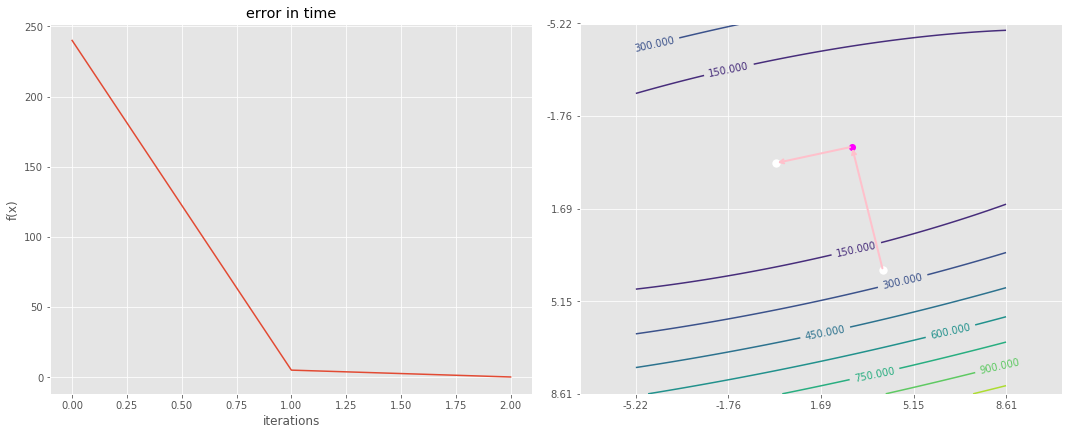

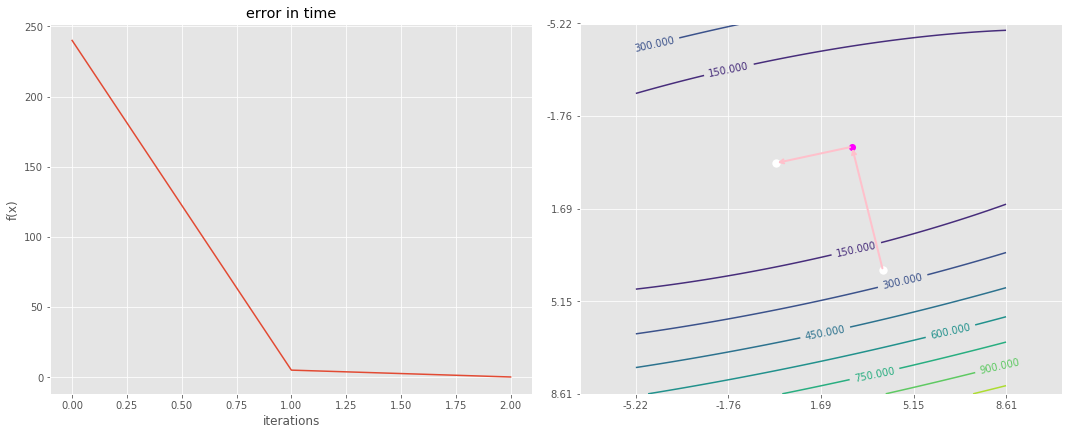

In [4]:
A = np.array([[1, 2], [2, 10]])
f = lambda x: x.T @ A @ x
gradient = lambda x: 2 * A @ x
hesian = lambda x: 2 * A

run_gd(f, gradient, eta=0.01, d=2)
run_newton(f, gradient, hesian, d=2)
run_cg(f, gradient, initial_x = np.array([4.,4.]))
run_cg(f, gradient, initial_x = np.array([4.,4.]), fletcher=True)

Czas na funkcje niewypukłe:
![Rosenbrock](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Rosenbrock%27s_function_in_3D.pdf/page1-640px-Rosenbrock%27s_function_in_3D.pdf.jpg "Rosenbrock function")
$$f(x,y)=100*(y-x^2)^2+(1-x)^2$$
Przetestuj kilka punktów startowych np. $[0,0], [-1.5,2.5],[1.7,2.7], [-.3,.85], [10,10]$. Funkcja osiąga minimum w punkcie $[1,1]$ - sprawdź w jakich sytuacjach jesteś w stanie uzyskać optimum globalne.

Uwaga: Do testowania niektórych punktów startowych zakomentuj algorytm spadku wzdłuż gradientu (lub znacznie zmniejsz $\eta$) - jest to trudna funkcja do optymalizacji i algorytm potrafi "zoptymalizować" funkcję do $\infty$, co powoduje problemy z rysowaniem wykresu.

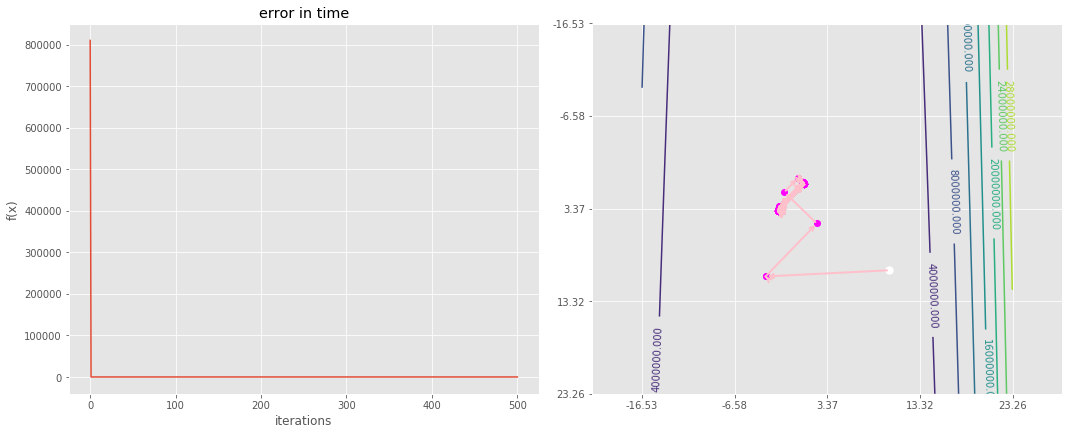

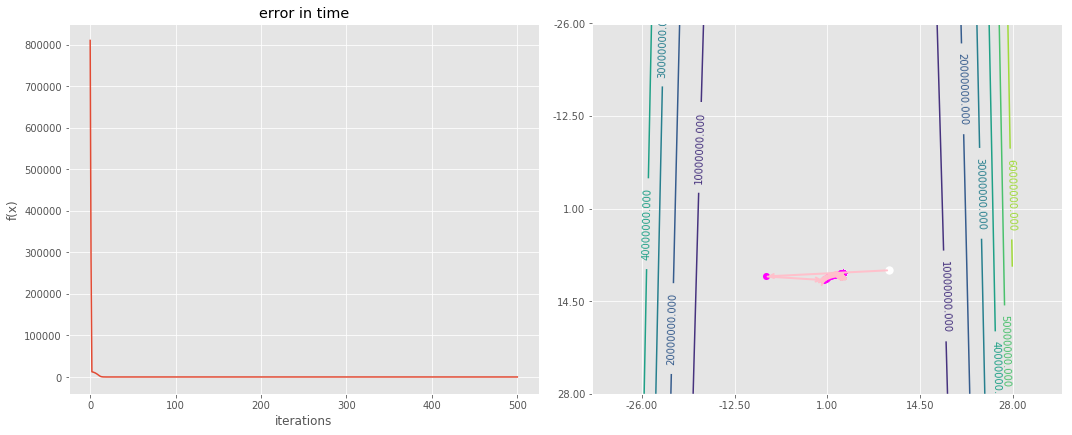

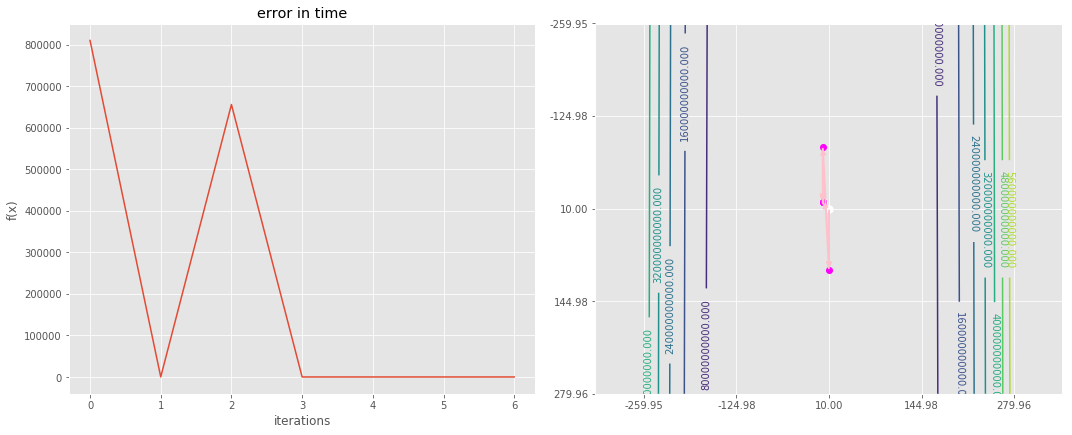

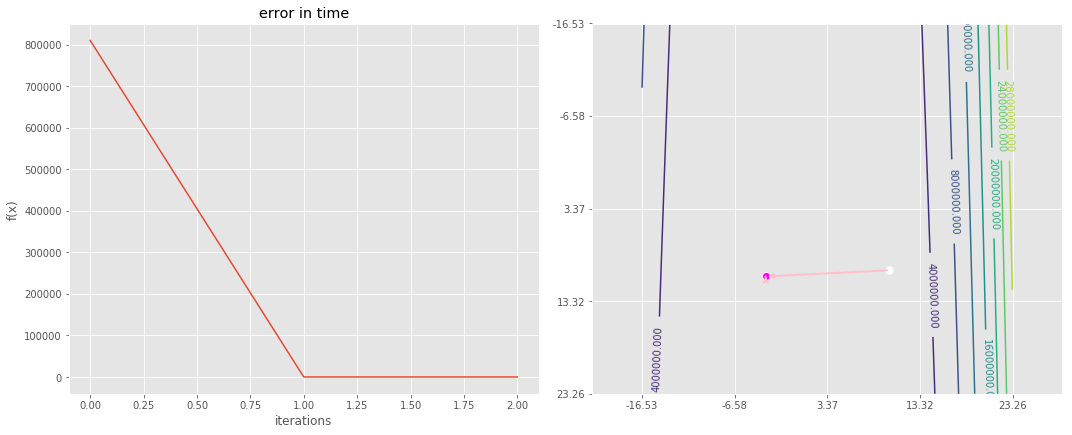

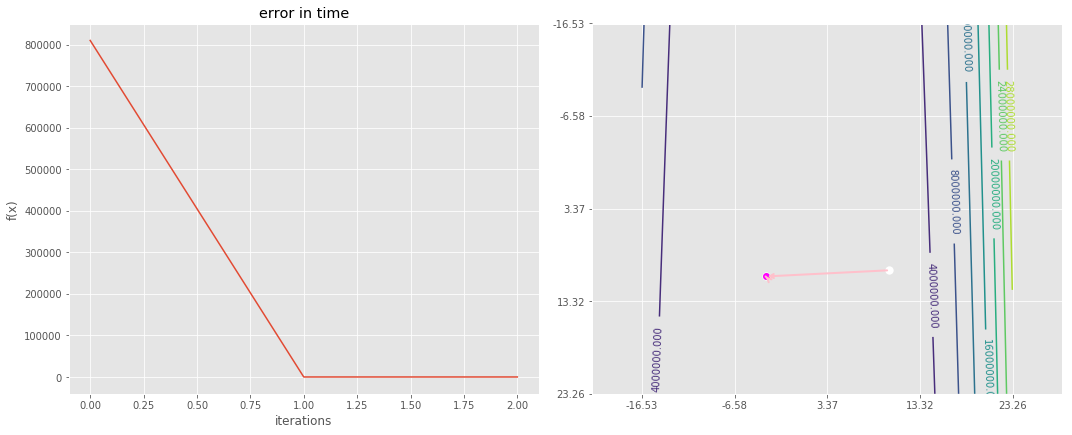

In [5]:
f = lambda x: 100*(x[1]-x[0]**2)**2+(1-x[0])**2
gradient = lambda x: np.array([-400*(x[1]-x[0]**2)*x[0]-2*(1-x[0]), 200*(x[1]-x[0]**2)])
hesian = lambda x: np.array([[2-400*x[1]+1200*x[0]**2,-400*x[0]],[-400*x[0],200]])


initial_x = np.array([10.0,10.0])

run_cauchy(f, gradient, initial_x)
run_gd(f, gradient, eta=0.00005, d=2, initial_x=initial_x) 
run_newton(f, gradient, hesian, d=2, initial_x=initial_x)
pr = run_cg(f, gradient, initial_x = initial_x)
fl= run_cg(f, gradient, initial_x = initial_x, fletcher=True)


Porównaj działanie Twojej implementacji algorytmu gradientów sprzeżonych z działaniem profesjonalnej implementacji z biblioteki.

In [6]:
from scipy.optimize import minimize
r = minimize(f, initial_x, method='CG', jac=gradient, options={'gtol': 1e-5, 'disp': True})
print(r)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 44
         Function evaluations: 102
         Gradient evaluations: 102
     fun: 5.3375877725339195e-15
     jac: array([7.14675109e-08, 3.73012288e-08])
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 44
    njev: 102
  status: 0
 success: True
       x: array([1.00000007, 1.00000015])


Wydaje się, że profesjonalna implementacja jest lepsza niż Twoja. Pomiędzy tymi implementacjami są dwie różnice
- mechanizm resetowania tj. zapominania historii poprzednich kierunków po $n$ iteracjach (są nawet bardziej złożone warunki na resetowanie)
- mechanizm przeszukiwania liniowego - w praktyce nie korzystamy ze złotego podziału do optymalizowania długości kroku *dokładnie* (duża złożoność i założenie o unimodalności) tylko używamy technik jak poznana na wykładzie reguła Armijo. Dla gradientów sprzężonych ta reguła jednak nie wystarcza i używa się ich dalszych rozszerzeń. Możesz spróbować rozszerzyć Twoją implementację o taką właśnie ciutkę lepszą technikę (których omówienie wykracza poza zakres kursu):
```
eta = aprroximate_line_search (f, gradient, x (dany punkt), d (kierunek optymalizacji))
```
Uwaga! Czasami ta metoda nie jest w stanie znaleźć dobrej długości kroku i wtedy wyrzuca błąd `LineSearchError` - trzeba go złapać i np. zakończyć działanie metody.

Po implementacji - sprawdź jak teraz działa algorytm dla funkcji kwadratowej.

Przetestuj funkcję Himmelblau
![Himmelblau](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Himmelblau_function.svg/300px-Himmelblau_function.svg.png "Himmelblau function")

$$f(x,y)=(x^{2}+y-11)^{2}+(x+y^{2}-7)^{2} $$Jak widać na rysunku funkcja osiąga kilka minimów.
$${\text{Min}}={\begin{cases}f\left(3.0,2.0\right)&=0.0\\f\left(-2.805118,3.131312\right)&=0.0\\f\left(-3.779310,-3.283186\right)&=0.0\\f\left(3.584428,-1.848126\right)&=0.0\\\end{cases}}$$
Tak jak poprzednio przetestuj kilka punktów startowych np. $[0,0], [-1.5,2.5],[1.7,2.7], [-.3,.85]$

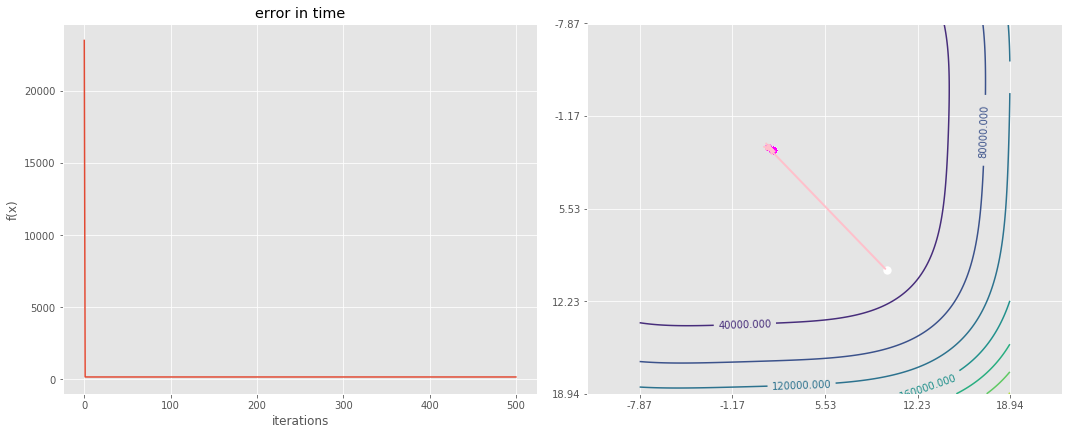

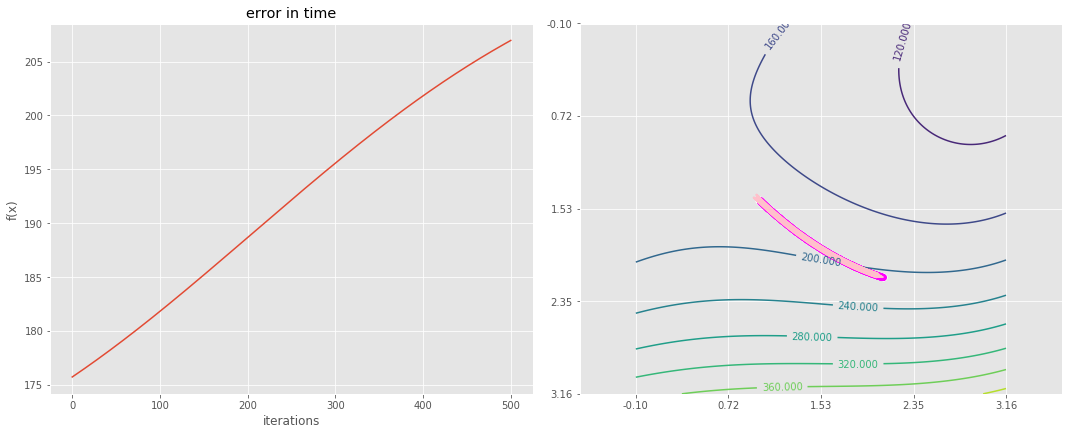

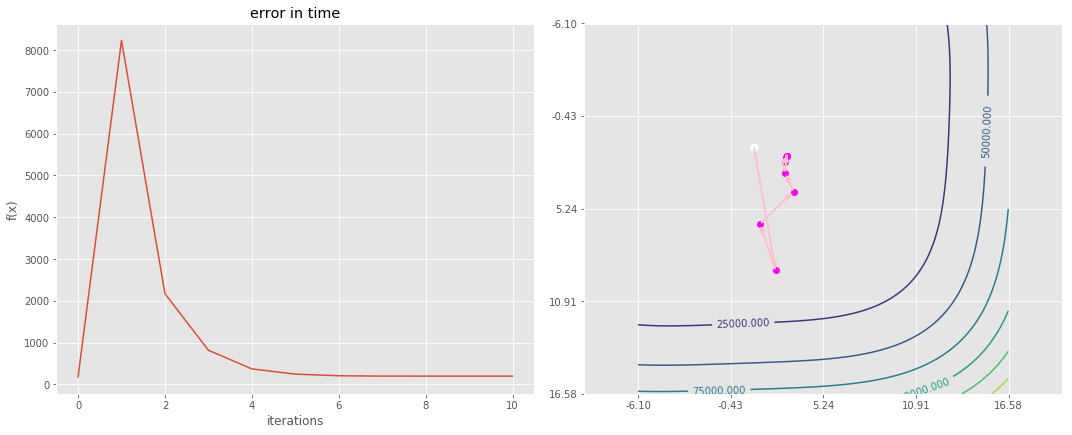

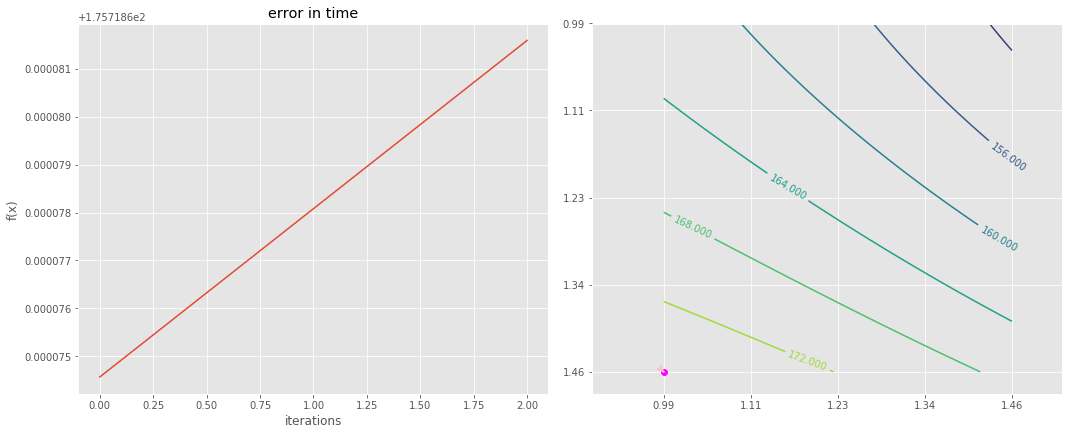

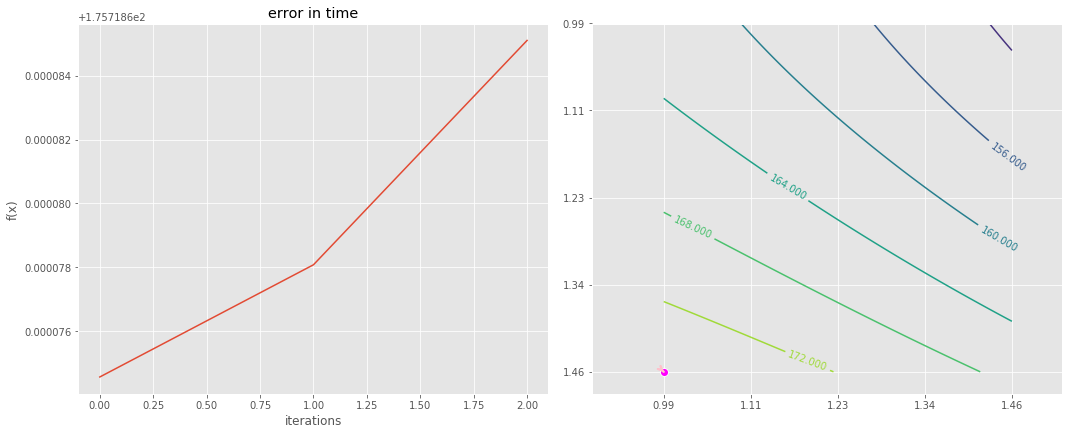

In [7]:
f = lambda x: (x[0]**2+x[1]-11)**2+(x[0]+x[1]**2+7)**2
gradient = lambda x: np.array([4*x[0]*(x[0]**2+x[1]-11) +2*(x[0]+x[1]**2-7), 
                               2*(x[0]**2+x[1]-11)+4*x[1]*(x[0]+x[1]**2-7) ])
hesian = lambda x: np.array([[12*x[0]**2+2-44+4*x[1],4*x[0]+4*x[1]],
                             [4*x[0]+4*x[1], 2-(7*4)+4*x[0]+12*x[1]**2]])

inital_x = np.array([0.99,1.46])

run_cauchy(f, gradient, initial_x)
run_gd(f, gradient, eta=0.00005, d=2, initial_x=inital_x)  
run_newton(f, gradient, hesian, d=2, initial_x=inital_x)
pr = run_cg(f, gradient, initial_x =inital_x)
fl = run_cg(f, gradient, initial_x = inital_x, fletcher=True)

In [8]:
from scipy.optimize import minimize
r = minimize(f, inital_x, method='CG', jac=gradient, options={'gtol': 1e-5, 'disp': True})
print(r)

         Current function value: 175.718675
         Iterations: 0
         Function evaluations: 110
         Gradient evaluations: 98
     fun: 175.71867457000002
     jac: array([-41.654004, -39.769656])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 110
     nit: 0
    njev: 98
  status: 2
 success: False
       x: array([0.99, 1.46])
